In [60]:
api_key = ""
channel_id = ""

In [61]:
from googleapiclient.discovery import build
youtube = build("youtube", "v3", developerKey=api_key)

In [62]:
def get_channel_videos(channel_id):
    res = youtube.channels().list(id=channel_id,
                                 part="contentDetails").execute()
    playlist_id = res["items"][0]["contentDetails"]["relatedPlaylists"]["uploads"]
    
    videos = []
    next_page_token = None
    
    while 1:
        res = youtube.playlistItems().list(playlistId=playlist_id,
                                          part="snippet",
                                          maxResults=50,
                                          pageToken=next_page_token).execute()
        videos += res["items"]
        next_page_token = res.get("nextPageToken")
        
        if next_page_token is None:
            break
    
    return videos

In [63]:
videos = get_channel_videos(channel_id)

In [64]:
res = youtube.videos().list(id=videos[0]["snippet"]["resourceId"]["videoId"],
                           part="statistics").execute()

In [65]:
video_ids = list(map(lambda x:x['snippet']['resourceId']['videoId'], videos))

In [66]:
def get_videos_stats(video_ids):
    stats = []
    for i in range(0, len(video_ids), 50):
        res = youtube.videos().list(id=','.join(video_ids[i:i+50]),
                                   part='statistics').execute()
        stats += res['items']
    return stats

In [67]:
stats = get_videos_stats(video_ids)

# List Before Dataframe

In [92]:
publishedAt = []
title = []
viewCount = []
likeCount = []
dislikeCount = []
commentCount = []

for i in range(len(videos)):
    publishedAt.append(videos[i]['snippet']['publishedAt'])
    title.append(videos[i]['snippet']['title'])
    viewCount.append(stats[i]['statistics']['viewCount'])
    likeCount.append(stats[i]['statistics']['likeCount'])
    dislikeCount.append(stats[i]['statistics']['dislikeCount'])
    commentCount.append(stats[i]['statistics']['commentCount'])

# Dataframe
공개일, 제목, 조회수, 좋아요수, 싫어요수, 댓글수

zip을 이용하여 list를 vertical하게 DataFrame으로 만든다.  
참고 링크 : https://stackoverflow.com/questions/54644722/how-to-vertically-align-lists-to-pandas-dataframe-in-python

In [93]:
import pandas as pd
names = ['publishedAt', 'title', 'viewCount', 'likeCount', 'dislikeCount', 'commentCount']
df = pd.DataFrame(data=list(zip(publishedAt, title, viewCount, likeCount, dislikeCount, commentCount)),
                 columns=names)

# int로 변환

In [94]:
df['viewCount'] = df['viewCount'].astype(int)
df['likeCount'] = df['likeCount'].astype(int)
df['dislikeCount'] = df['dislikeCount'].astype(int)
df['commentCount'] = df['commentCount'].astype(int)

# 좋아요/싫어요 비율

In [95]:
# 0으로 나누는 걸 방지하기 위해 0.001을 더했다.
df['likeRatio'] = df['likeCount'] / (df['likeCount'] + df['dislikeCount'] + 0.01)
len(df)

2597

# 제목에 '에이치엘비'가 없다면 Drop하기

In [96]:
df['에이치엘비'] = df['title'].str.contains('에이치엘비')
df = df.loc[(df['에이치엘비'] == True)]
len(df)

1451

# 제목에 '에이치엘비생명과학'이 있다면 Drop하기

In [97]:
df['에이치엘비생명과학'] = df['title'].str.contains('에이치엘비생명과학')
df = df.loc[df['에이치엘비생명과학'] == False]
len(df)

1414

# 제목에 '에이치엘비제약'이 있다면 Drop하기

In [98]:
df['에이치엘비제약'] = df['title'].str.contains('에이치엘비제약')
df = df.loc[(df['에이치엘비제약'] == False)]
len(df)

1386

# 라이브 영상 Drop하기

In [99]:
import re
def reg_live(word):
    if re.compile('라이브').search(word):
        return True
    else:
        return False

In [100]:
df['live'] = df['title'].apply(reg_live)

In [101]:
df = df.loc[(df['live'] == False)]
len(df)

1363

# 과거 절반 데이터 Drop하기

In [102]:
df = df[:int(len(df)/2)]
len(df)

681

# 최근 데이터 Drop하기
공개된지 몇 시간 되지 않아 아직 조회수가 채워지지 않았기 때문에 같은 기준으로 분석할 수 없다.

In [103]:
df = df[5:]
len(df)

676

# 필요한 column 빼고 전부 Drop하기

In [104]:
df = df[['title', 'viewCount']]

# 전처리 완료

In [105]:
df.head()

,title,viewCount
5,에이치엘비 베리스모 CAR-T 중국 시장 진출 본격화하면 현재 긴밀한 관계를 맺고 ...,5496
6,에이치엘비 CAR-T 상업화 최소 3년이상 앞당길 수 있다!! CAR-T세포가 활성...,7093
7,에이치엘비 주주 오세훈 서울시장 당선!!,6245
8,에이치엘비 진양곤 회장은 코르키로부터 확보했던 넥스트사이언스의 메자닌에 대한 콜옵션...,8670
9,에이치엘비 증선위 뉴스기사가 없는 것으로 보아 열리지 않고 무기한 연기 가능성!!,7720


# 분석 시작 

# 진양곤이 제목으로 들어가면 조회수가 높을까?

re.I를 사용하면 대소문자 구분 없이 찾아낸다.  
참고 링크 : https://itholic.github.io/python-re-uplow/

In [106]:
import re
def reg_func(word):
    if re.compile('진양곤|진회장').search(word):
        return True
    else:
        return False

In [107]:
df['jin'] = df['title'].apply(reg_func)

In [108]:
df.loc[(df['jin'] == True)].head()

,title,viewCount,jin
8,에이치엘비 진양곤 회장은 코르키로부터 확보했던 넥스트사이언스의 메자닌에 대한 콜옵션...,8670,True
16,에이치엘비 10년전 진양곤회장의 놀라운 매수 평단가!!,11076,True
18,에이치엘비 진양곤회장이 인수한 넥스트사이언스 치매 진단키트도 개발한다!!,4430,True
27,에이치엘비는 내리고 진양곤회장이 지분취득한 종목만 잘 가는 현상,11519,True
49,에이치엘비는 지분을 다 채우지 않고도 자회사들에 대한 뛰어난 지배능력을 보여준다!!...,7543,True


# 각 Sample Size 구하기
True는 제목에 진양곤 또는 진회장이 있는 영상(21개)     
False는 제목에 진양곤 또는 진회장이 없는 영상(655개)

In [109]:
df.groupby('jin').viewCount.size()

jin
False    655
True      21
Name: viewCount, dtype: int64

# 각 조회수 평균 구하기
True는 제목에 진양곤 또는 진회장이 있는 영상(13,512회)     
False는 제목에 진양곤 또는 진회장이 없는 영상(7,385회)

In [111]:
df.groupby('jin').viewCount.mean()

jin
False     7385.392366
True     13512.857143
Name: viewCount, dtype: float64

# t-test하기

In [113]:
from scipy.stats import ttest_ind
jin = df.loc[df['jin'] == True].viewCount
no_jin = df.loc[df['jin'] == False].viewCount

In [114]:
ttest_ind(jin, no_jin)

Ttest_indResult(statistic=5.579958755493323, pvalue=3.48696876540512e-08)

# Barchart

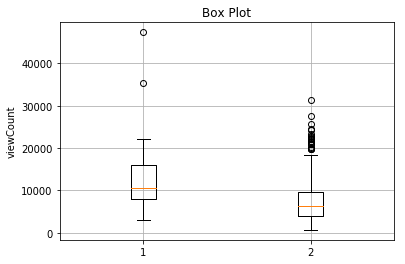

In [115]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.boxplot([jin, no_jin])
plt.xlabel('')
plt.ylabel('viewCount')
plt.title('Box Plot')
plt.grid()
plt.show()

# Results
제목에 제목에 진양곤 또는 진회장이 있는 영상의 조회수 평균은 13,512회  
제목에 제목에 진양곤 또는 진회장이 없는 영상의 조회수 평균은 7,385회  
(p=3.487)  
조회수가 3만이 넘는 아웃라이어 영상이 2개나 있어 조회수 평균이 상당히 높게 나왔다. 그러나 통계적 유의미성을 달성하지 못했다.

# Conclusion
향후 데이터가 모이면 한 번 더 통계 분석한다.